# Initialization

In [1]:
import sys, os, logging
sys.path.append(os.getenv('VIRTUAL_ENV')+'/lib/python3.8/site-packages/')

import curves as c

import matplotlib.pyplot as plt
pc=1e-2
year = 1
month = year/12
day = month/30
week = 7*day

import pandas as pd
pd.set_option('display.max_colwidth', 100)


In [2]:
def curve_build_info(curve):
    '''Show info on the curve'''
    data = []
    for instr in curve.GetInstruments():
        try:
            v1 = instr.Value()
            v2 = instr.Eval(curve)
            data.append({
                'maturity':instr.GetMaturity(),
                'Value':v1,
                'Eval(Curve)':v2,
                'diff':v1-v2,
                'instrument':str(instr)
            })
        except Exception as e:
            logging.error(f'Failed to eval {instr}: {e}')
    df = pd.DataFrame(data)
    df.style.set_caption(f'{curve}')
    return df

## Data
Define functions which *adds* instruments to the curve construction

In [3]:
def add_eur_libor_quotes_1(curve):
    # https://www.global-rates.com/en/interest-rates/libor/libor.aspx
    
    # date: 06-25-2021
    data = [
        {'t0':0, 'length': 1*day,   'rate': -0.58471*pc},
        {'t0':0, 'length': 1*week,  'rate': -0.57571*pc},
        {'t0':0, 'length': 1*month, 'rate': -0.57786*pc},
        {'t0':0, 'length': 2*month, 'rate': -0.55857*pc},
        {'t0':0, 'length': 3*month, 'rate': -0.54614*pc},
        {'t0':0, 'length': 6*month, 'rate': -0.52614*pc},
        {'t0':0, 'length': 1*year,  'rate': -0.48357*pc},
    ]
    for v in data:
        curve.Add(c.ForwardRateAgreement(v['t0'],v['length'],v['rate']))

In [4]:
def add_eur_libor_quotes_2(curve):
    # https://www.chathamfinancial.com/technology/european-market-rates
    
    # date: 06-25-2021
    data = [
        {'t0':0, 'length': 1*month, 'rate': -0.56200*pc},
        {'t0':0, 'length': 3*month, 'rate': -0.53800*pc},
        {'t0':0, 'length': 6*month, 'rate': -0.51300*pc},
        {'t0':0, 'length': 1*year,  'rate': -0.47800*pc},
    ]
    for v in data:
        curve.Add(c.ForwardRateAgreement(v['t0'],v['length'],v['rate']))

In [5]:
def add_swaps(curve,curve_float_leg=None):
    if curve_float_leg is None:
        curve_float_leg = curve
    t0 = 0
    dt = year*0.25
    swaps = {
         1*year:  0.19*pc,
         2*year:  0.32*pc,
         3*year:  0.55*pc,
         5*year:  0.93*pc,
         7*year:  1.20*pc,
        10*year:  1.45*pc,
        15*year:  1.53*pc,
        30*year:  1.78*pc
    }
    for period,rate in swaps.items():

        swap = c.Swap()

        # fixed rate: payed quartely
        swap.lfix = c.LegFixed(t0,dt,round(period/dt),rate)

        # floating rate: payed quartely
        dt = year*0.25

        swap.lflt = c.LegFloat(t0,dt,round(period/dt),curve_float_leg)
        curve.Add(swap)


In [6]:
def f(add_data,interpolations,plot_points=1000):
    curves = {}
    build_info = {}
    tmax = None

    for itype in interpolations:
        curve = c.YieldCurve()
        curves[itype] = curve
        try:
            add_data(curve)
            curve.Build(itype,0)
            tmax = curve.GetX()[-1]
        except Exception as e:
            logging.error(f'Problem with {itype} interpolation: {e}')
        build_info[itype] = curve_build_info(curve)

    if tmax:
        vx = [(tmax*i)/(plot_points-1) for i in range(plot_points)]

        fig1, ax1 = plt.subplots()
        ax1.set_xlabel('Time, year')
        ax1.set_ylabel('Instantaneous Rate / year, %')

        fig2, ax2 = plt.subplots()
        ax2.set_xlabel('Time, year')
        ax2.set_ylabel('Forward Rate / year, %')
        
        for itype,curve in curves.items():
            ax1.plot(
                vx,
                [curve(t)/pc for t in vx],
                label=str(itype)
            )
            ax2.plot(
                vx,
                [curve.GetForwardRate(0,t)/pc for t in vx],
                label=str(itype)
            )
#        loc = 'upper bottom'
#        ax1.legend(loc=loc, shadow=True)
#        ax2.legend(loc=loc, shadow=True)
        ax1.legend(shadow=True)
        ax2.legend(shadow=True)

    return {
        'curves':curves,
        'build_info':build_info,
        'plots' :{
            'InstantaneousRates': fig1,
            'ForwardRates': fig2,
        }
    }

In [7]:
interpolations = [
    c.Interpolator1D.Type.PiecewiseConstant,
    c.Interpolator1D.Type.Linear,
    c.Interpolator1D.Type.CubicSpline,
#    c.Interpolator1D.Type.Akima,
#    c.Interpolator1D.Type.Steffen
]

# Building with FRAs (data1)

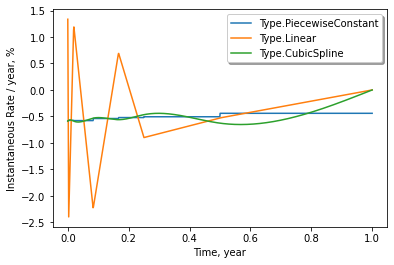

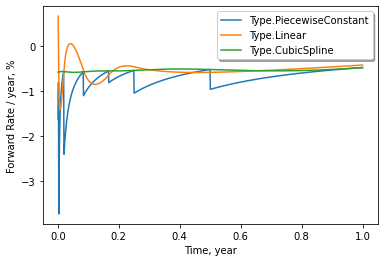

In [8]:
r = f(add_eur_libor_quotes_1,interpolations)

In [9]:
r['build_info'][c.Interpolator1D.Type.PiecewiseConstant]

,maturity,Value,Eval(Curve),diff,instrument
0,0.002778,-0.005847,-0.005836,-1.066085e-05,ForwardRateAgreement start=0 length=0.00277778 rate=-0.0058471
1,0.019444,-0.005757,-0.005756,-6.356277e-07,ForwardRateAgreement start=0 length=0.0194444 rate=-0.0057571
2,0.083333,-0.005779,-0.005779,7.050112e-07,ForwardRateAgreement start=0 length=0.0833333 rate=-0.0057786
3,0.166667,-0.005586,-0.005586,-7.916242e-09,ForwardRateAgreement start=0 length=0.166667 rate=-0.0055857
4,0.250000,-0.005461,-0.005461,-9.918585e-08,ForwardRateAgreement start=0 length=0.25 rate=-0.0054614
5,0.500000,-0.005261,-0.005261,8.847564e-09,ForwardRateAgreement start=0 length=0.5 rate=-0.0052614
6,1.000000,-0.004836,-0.004836,-3.725290e-09,ForwardRateAgreement start=0 length=1 rate=-0.0048357


In [10]:
r['build_info'][c.Interpolator1D.Type.Linear]

,maturity,Value,Eval(Curve),diff,instrument
0,0.002778,-0.005847,-0.005579,-0.000268,ForwardRateAgreement start=0 length=0.00277778 rate=-0.0058471
1,0.019444,-0.005757,-0.006045,0.000287,ForwardRateAgreement start=0 length=0.0194444 rate=-0.0057571
2,0.083333,-0.005779,-0.005307,-0.000471,ForwardRateAgreement start=0 length=0.0833333 rate=-0.0057786
3,0.166667,-0.005586,-0.006499,0.000913,ForwardRateAgreement start=0 length=0.166667 rate=-0.0055857
4,0.250000,-0.005461,-0.004666,-0.000795,ForwardRateAgreement start=0 length=0.25 rate=-0.0054614
5,0.500000,-0.005261,-0.005901,0.000640,ForwardRateAgreement start=0 length=0.5 rate=-0.0052614
6,1.000000,-0.004836,-0.004271,-0.000565,ForwardRateAgreement start=0 length=1 rate=-0.0048357


In [11]:
r['build_info'][c.Interpolator1D.Type.CubicSpline]

,maturity,Value,Eval(Curve),diff,instrument
0,0.002778,-0.005847,-0.005836,-0.000011,ForwardRateAgreement start=0 length=0.00277778 rate=-0.0058471
1,0.019444,-0.005757,-0.005744,-0.000013,ForwardRateAgreement start=0 length=0.0194444 rate=-0.0057571
2,0.083333,-0.005779,-0.005786,0.000008,ForwardRateAgreement start=0 length=0.0833333 rate=-0.0057786
3,0.166667,-0.005586,-0.005584,-0.000001,ForwardRateAgreement start=0 length=0.166667 rate=-0.0055857
4,0.250000,-0.005461,-0.005463,0.000001,ForwardRateAgreement start=0 length=0.25 rate=-0.0054614
5,0.500000,-0.005261,-0.005269,0.000008,ForwardRateAgreement start=0 length=0.5 rate=-0.0052614
6,1.000000,-0.004836,-0.004835,-0.000001,ForwardRateAgreement start=0 length=1 rate=-0.0048357


# Building with FRAs (data2)

ERROR:root:Problem with Type.Linear interpolation: the iteration has not converged yet


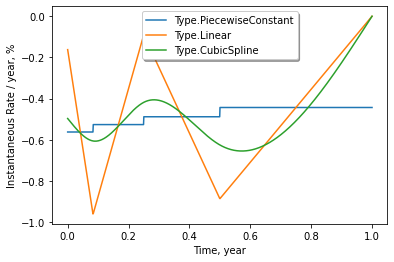

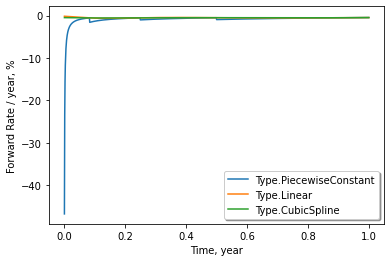

In [12]:
r = f(add_eur_libor_quotes_2,interpolations)

In [13]:
r['build_info'][c.Interpolator1D.Type.PiecewiseConstant]

,maturity,Value,Eval(Curve),diff,instrument
0,0.083333,-0.00562,-0.005621,5.932525e-07,ForwardRateAgreement start=0 length=0.0833333 rate=-0.00562
1,0.250000,-0.00538,-0.005380,-1.280569e-07,ForwardRateAgreement start=0 length=0.25 rate=-0.00538
2,0.500000,-0.00513,-0.005130,-9.452924e-08,ForwardRateAgreement start=0 length=0.5 rate=-0.00513
3,1.000000,-0.00478,-0.004780,5.541369e-08,ForwardRateAgreement start=0 length=1 rate=-0.00478


In [14]:
r['build_info'][c.Interpolator1D.Type.Linear]

,maturity,Value,Eval(Curve),diff,instrument
0,0.083333,-0.00562,-0.005621,5.932525e-07,ForwardRateAgreement start=0 length=0.0833333 rate=-0.00562
1,0.250000,-0.00538,-0.005380,-1.280569e-07,ForwardRateAgreement start=0 length=0.25 rate=-0.00538
2,0.500000,-0.00513,-0.005130,-3.324822e-07,ForwardRateAgreement start=0 length=0.5 rate=-0.00513
3,1.000000,-0.00478,-0.004780,5.541369e-08,ForwardRateAgreement start=0 length=1 rate=-0.00478


In [15]:
r['build_info'][c.Interpolator1D.Type.CubicSpline]

,maturity,Value,Eval(Curve),diff,instrument
0,0.083333,-0.00562,-0.005619,-8.363277e-07,ForwardRateAgreement start=0 length=0.0833333 rate=-0.00562
1,0.250000,-0.00538,-0.005380,-1.280569e-07,ForwardRateAgreement start=0 length=0.25 rate=-0.00538
2,0.500000,-0.00513,-0.005130,1.429580e-07,ForwardRateAgreement start=0 length=0.5 rate=-0.00513
3,1.000000,-0.00478,-0.004780,-6.332994e-08,ForwardRateAgreement start=0 length=1 rate=-0.00478


# Building with SWAPs

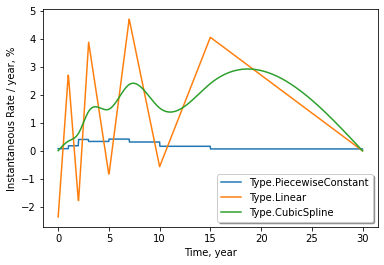

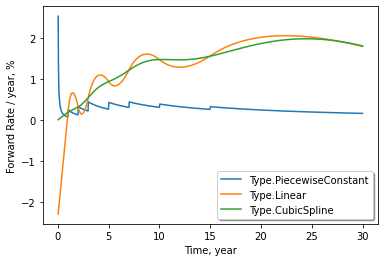

In [16]:
r = f(add_swaps,[c.Interpolator1D.Type.PiecewiseConstant,c.Interpolator1D.Type.Linear,c.Interpolator1D.Type.CubicSpline])

In [17]:
r['build_info'][c.Interpolator1D.Type.PiecewiseConstant]

,maturity,Value,Eval(Curve),diff,instrument
0,1.0,0.0,1.164153e-10,-1.164153e-10,Swap: (LegFixed t0=0 dt=0.25 n=4) (LegFloat t0=0 dt=0.25 n=4)
1,2.0,0.0,0.000000e+00,0.000000e+00,Swap: (LegFixed t0=0 dt=0.25 n=8) (LegFloat t0=0 dt=0.25 n=8)
2,3.0,0.0,1.862645e-09,-1.862645e-09,Swap: (LegFixed t0=0 dt=0.25 n=12) (LegFloat t0=0 dt=0.25 n=12)
3,5.0,0.0,-3.725290e-09,3.725290e-09,Swap: (LegFixed t0=0 dt=0.25 n=20) (LegFloat t0=0 dt=0.25 n=20)
4,7.0,0.0,0.000000e+00,0.000000e+00,Swap: (LegFixed t0=0 dt=0.25 n=28) (LegFloat t0=0 dt=0.25 n=28)
5,10.0,0.0,1.490116e-08,-1.490116e-08,Swap: (LegFixed t0=0 dt=0.25 n=40) (LegFloat t0=0 dt=0.25 n=40)
6,15.0,0.0,0.000000e+00,0.000000e+00,Swap: (LegFixed t0=0 dt=0.25 n=60) (LegFloat t0=0 dt=0.25 n=60)
7,30.0,0.0,-1.192093e-07,1.192093e-07,Swap: (LegFixed t0=0 dt=0.25 n=120) (LegFloat t0=0 dt=0.25 n=120)


In [18]:
r['build_info'][c.Interpolator1D.Type.Linear]

,maturity,Value,Eval(Curve),diff,instrument
0,1.0,0.0,-4.605390e-07,4.605390e-07,Swap: (LegFixed t0=0 dt=0.25 n=4) (LegFloat t0=0 dt=0.25 n=4)
1,2.0,0.0,1.294073e-06,-1.294073e-06,Swap: (LegFixed t0=0 dt=0.25 n=8) (LegFloat t0=0 dt=0.25 n=8)
2,3.0,0.0,-7.767230e-07,7.767230e-07,Swap: (LegFixed t0=0 dt=0.25 n=12) (LegFloat t0=0 dt=0.25 n=12)
3,5.0,0.0,1.091510e-06,-1.091510e-06,Swap: (LegFixed t0=0 dt=0.25 n=20) (LegFloat t0=0 dt=0.25 n=20)
4,7.0,0.0,3.099442e-06,-3.099442e-06,Swap: (LegFixed t0=0 dt=0.25 n=28) (LegFloat t0=0 dt=0.25 n=28)
5,10.0,0.0,-1.415610e-06,1.415610e-06,Swap: (LegFixed t0=0 dt=0.25 n=40) (LegFloat t0=0 dt=0.25 n=40)
6,15.0,0.0,-1.952052e-06,1.952052e-06,Swap: (LegFixed t0=0 dt=0.25 n=60) (LegFloat t0=0 dt=0.25 n=60)
7,30.0,0.0,-5.960464e-08,5.960464e-08,Swap: (LegFixed t0=0 dt=0.25 n=120) (LegFloat t0=0 dt=0.25 n=120)


In [19]:
r['build_info'][c.Interpolator1D.Type.CubicSpline]

,maturity,Value,Eval(Curve),diff,instrument
0,1.0,0.0,-7.892959e-08,7.892959e-08,Swap: (LegFixed t0=0 dt=0.25 n=4) (LegFloat t0=0 dt=0.25 n=4)
1,2.0,0.0,-5.215406e-08,5.215406e-08,Swap: (LegFixed t0=0 dt=0.25 n=8) (LegFloat t0=0 dt=0.25 n=8)
2,3.0,0.0,-3.390014e-07,3.390014e-07,Swap: (LegFixed t0=0 dt=0.25 n=12) (LegFloat t0=0 dt=0.25 n=12)
3,5.0,0.0,-4.842877e-08,4.842877e-08,Swap: (LegFixed t0=0 dt=0.25 n=20) (LegFloat t0=0 dt=0.25 n=20)
4,7.0,0.0,1.117587e-07,-1.117587e-07,Swap: (LegFixed t0=0 dt=0.25 n=28) (LegFloat t0=0 dt=0.25 n=28)
5,10.0,0.0,1.639128e-07,-1.639128e-07,Swap: (LegFixed t0=0 dt=0.25 n=40) (LegFloat t0=0 dt=0.25 n=40)
6,15.0,0.0,8.940697e-08,-8.940697e-08,Swap: (LegFixed t0=0 dt=0.25 n=60) (LegFloat t0=0 dt=0.25 n=60)
7,30.0,0.0,2.980232e-08,-2.980232e-08,Swap: (LegFixed t0=0 dt=0.25 n=120) (LegFloat t0=0 dt=0.25 n=120)
